# 4. Geometry operations
https://py.geocompx.org/04-geometry-operations

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import geopandas as gpd
import topojson as tp
import rasterio
import rasterio.plot
import rasterio.warp
import rasterio.mask

In [2]:
seine = gpd.read_file('data/seine.gpkg')
us_states = gpd.read_file('data/us_states.gpkg')
nz = gpd.read_file('data/nz.gpkg')
src = rasterio.open('data/dem.tif')
src_elev = rasterio.open('output/elev.tif')

In [3]:
seine

,name,geometry
0,Marne,"MULTILINESTRING ((879955.277 6755724.892, 8784..."
1,Seine,"MULTILINESTRING ((828893.615 6713872.817, 8282..."
2,Yonne,"MULTILINESTRING ((773482.137 6660431.284, 7713..."


In [4]:
us_states.explore()

In [5]:
nz.explore()

## 4.2 Geometric operations on vector data

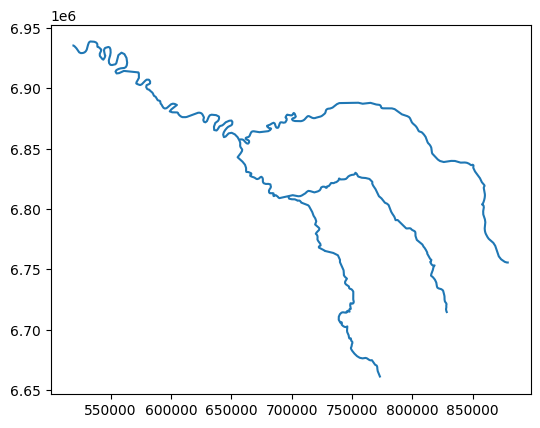

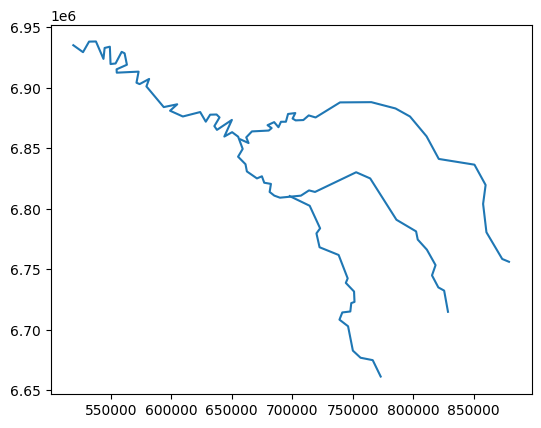

In [6]:
seine_simp = seine.simplify(2000)
seine.plot();
seine_simp.plot();

In [7]:
print(f'Original: {sys.getsizeof(seine)} bytes')
print(f'Simplified: {sys.getsizeof(seine_simp)} bytes')

Original: 350 bytes
Simplified: 188 bytes


In [8]:
us_states9311= us_states.to_crs(9311)
us_states_simp1 = us_states9311.simplify(100000)

In [9]:
topo = tp.Topology(us_states9311, prequantize=False)
us_states_simp2 = topo.toposimplify(100000).to_gdf()

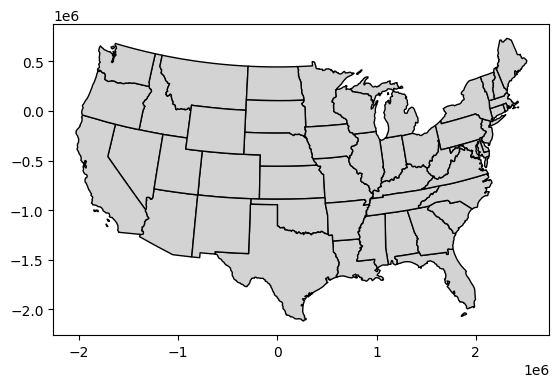

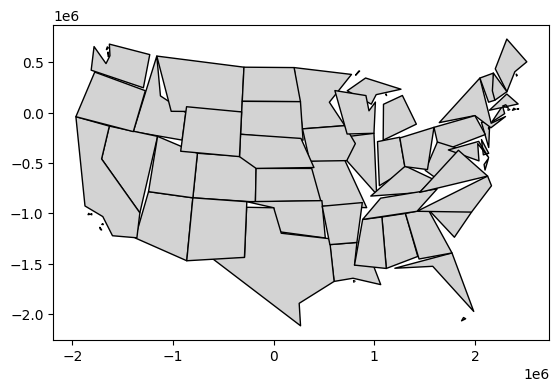

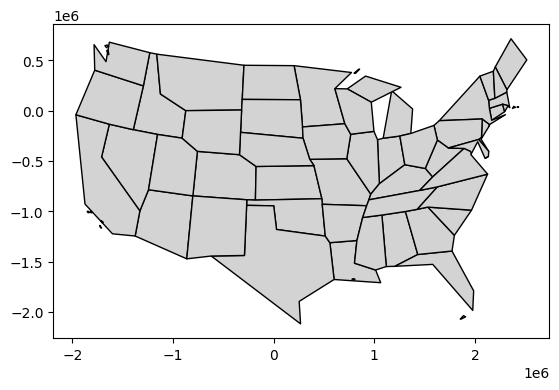

In [10]:
us_states9311.plot(color='lightgrey', edgecolor='black');
us_states_simp1.plot(color='lightgrey', edgecolor='black');
us_states_simp2.plot(color='lightgrey', edgecolor='black');

how does representative_point() work?
https://gis.stackexchange.com/questions/414260/how-does-geopandas-representative-point-work

In [11]:
nz_centroid = nz.centroid
seine_centroid = seine.centroid

nz_pos = nz.representative_point()
seine_pos = seine.representative_point()


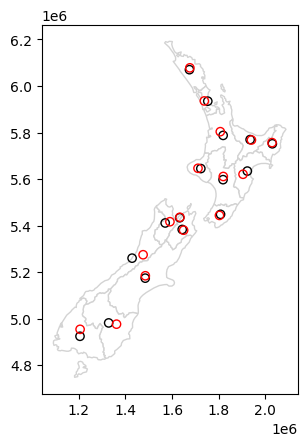

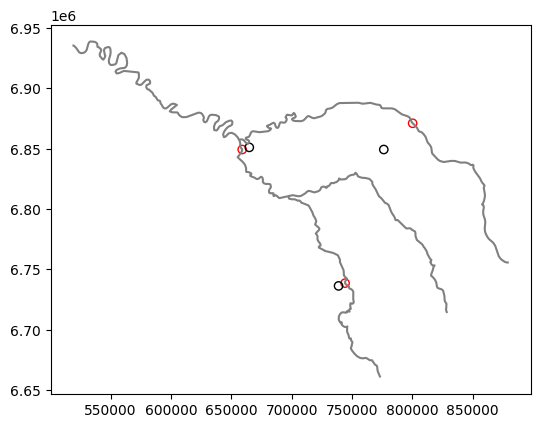

In [13]:
base = nz.plot(color='white', edgecolor='lightgrey')
nz_centroid.plot(ax=base, color='None', edgecolor='black')
nz_pos.plot(ax=base, color='None', edgecolor='red');

base = seine.plot(color='grey')
seine_pos.plot(ax=base, color='None', edgecolor='red')
seine_centroid.plot(ax=base, color='None', edgecolor='black');

In [14]:
seine_buff_5km = seine.buffer(5000)
seine_buff_50km = seine.buffer(50000)

<Axes: >

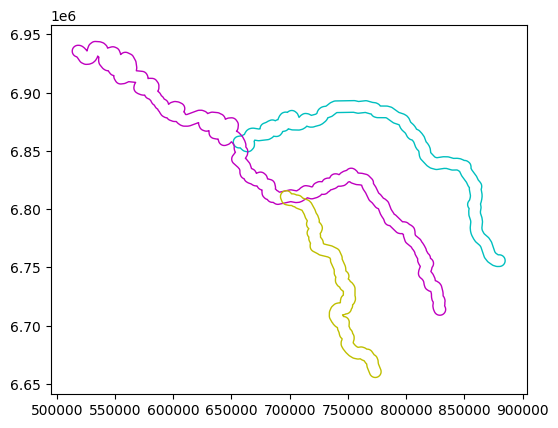

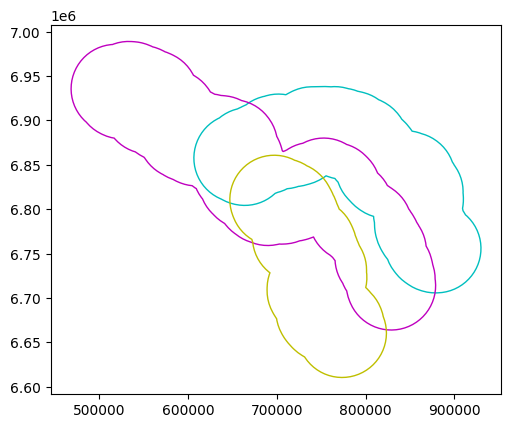

In [15]:
seine_buff_5km.plot(color='none', edgecolor=['c','m','y'])
seine_buff_50km.plot(color='none', edgecolor=['c','m','y'])

In [17]:
seine_buff_5km

0    POLYGON ((657550.332 6852587.977, 657528.383 6...
1    POLYGON ((517151.801 6930724.103, 516742.424 6...
2    POLYGON ((701519.74 6813075.492, 702765.277 68...
dtype: geometry

In [18]:
seine['geometry_5km'] = seine.buffer(5000)
seine

,name,geometry,geometry_5km
0,Marne,"MULTILINESTRING ((879955.277 6755724.892, 8784...","POLYGON ((657550.332 6852587.977, 657528.383 6..."
1,Seine,"MULTILINESTRING ((828893.615 6713872.817, 8282...","POLYGON ((517151.801 6930724.103, 516742.424 6..."
2,Yonne,"MULTILINESTRING ((773482.137 6660431.284, 7713...","POLYGON ((701519.74 6813075.492, 702765.277 68..."


In [19]:
seine = seine.set_geometry('geometry')
seine = seine.drop('geometry_5km', axis=1)

### 4.2.4 Affine transformation (on-working)

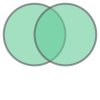

In [20]:
x = shapely.Point((0,0)).buffer(1)
y = shapely.Point((1,0)).buffer(1)

shapely.GeometryCollection([x,y])

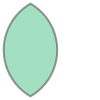

In [21]:
x.intersection(y)

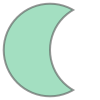

In [22]:
x.difference(y)

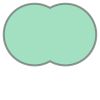

In [23]:
x.union(y)

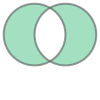

In [24]:
x.symmetric_difference(y)

In [25]:
geom1 = gpd.GeoSeries(x)
geom2 = geom1.translate(0, 1)
geom3 = geom1.translate(0, 2)
geom = pd.concat([geom1, geom2, geom3])
geom

0    POLYGON ((1 0, 0.99518 -0.09802, 0.98079 -0.19...
0    POLYGON ((1 1, 0.99518 0.90198, 0.98079 0.8049...
0    POLYGON ((1 2, 0.99518 1.90198, 0.98079 1.8049...
dtype: geometry

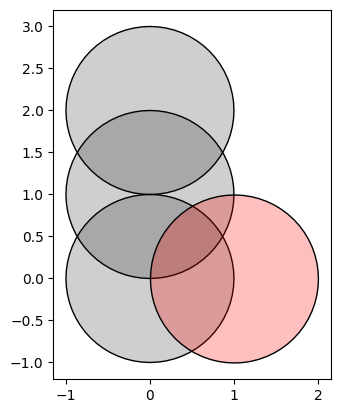

In [26]:
fig, ax = plt.subplots()
geom.plot(color='#00000030', edgecolor='black', ax=ax)
gpd.GeoSeries(y).plot(color='#FF000040', edgecolor='black', ax=ax);

In [27]:
geom_inter_y = geom.intersection(y)
geom_inter_y

0    POLYGON ((0.99518 -0.09802, 0.98079 -0.19509, ...
0    POLYGON ((0.99518 0.90198, 0.98079 0.80491, 0....
0                                        POLYGON EMPTY
dtype: geometry

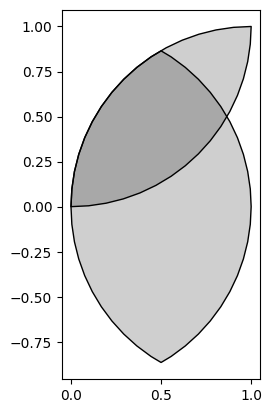

In [28]:
geom_inter_y.plot(color='#00000030', edgecolor='black');

In [29]:
bounds = x.union(y).bounds
bounds

(-1.0, -1.0, 2.0, 1.0)

In [30]:
np.random.seed(1)
n = 10
coords_x = np.random.uniform(bounds[0], bounds[2], n)
coords_y = np.random.uniform(bounds[1], bounds[3], n)
coords = list(zip(coords_x, coords_y))
coords

[(np.float64(0.251066014107722), np.float64(-0.1616109711934104)),
 (np.float64(1.1609734803264744), np.float64(0.370439000793519)),
 (np.float64(-0.9996568755479653), np.float64(-0.5910955005369651)),
 (np.float64(-0.0930022821044807), np.float64(0.7562348727818908)),
 (np.float64(-0.5597323275486609), np.float64(-0.9452248136041477)),
 (np.float64(-0.7229842156936066), np.float64(0.34093502035680445)),
 (np.float64(-0.4412193658669873), np.float64(-0.16539039526574606)),
 (np.float64(0.03668218112914323), np.float64(0.11737965689150331)),
 (np.float64(0.1903024226920098), np.float64(-0.7192261228095325)),
 (np.float64(0.6164502020100708), np.float64(-0.6037970218302424))]

In [31]:
pnt = [shapely.Point(i) for i in coords]
pnt = gpd.GeoSeries(pnt)

<Axes: >

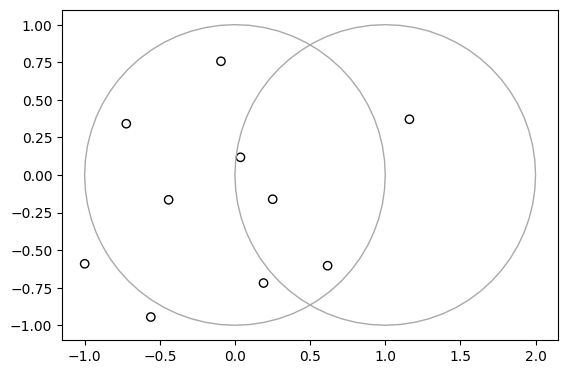

In [32]:
base = pnt.plot(color='none', edgecolor='black')
gpd.GeoSeries(x).plot(ax=base, color='none', edgecolor='darkgrey')
gpd.GeoSeries(y).plot(ax=base, color='none', edgecolor='darkgrey')

In [33]:
sel= pnt.intersects(x.intersection(y))
pnt1 = pnt[sel]
pnt1

0    POINT (0.25107 -0.16161)
7     POINT (0.03668 0.11738)
9     POINT (0.61645 -0.6038)
dtype: geometry

In [34]:
pnt2 = pnt.intersection(x.intersection(y))
pnt2

0    POINT (0.25107 -0.16161)
1                 POINT EMPTY
2                 POINT EMPTY
3                 POINT EMPTY
4                 POINT EMPTY
5                 POINT EMPTY
6                 POINT EMPTY
7     POINT (0.03668 0.11738)
8                 POINT EMPTY
9     POINT (0.61645 -0.6038)
dtype: geometry

In [39]:
type(x.intersects(y))

bool

In [38]:
type(x.intersection(y))

shapely.geometry.polygon.Polygon

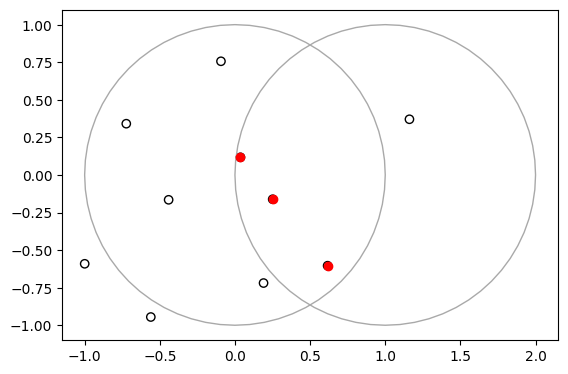

In [35]:
base = pnt.plot(color='none', edgecolor='black')
gpd.GeoSeries(x).plot(ax=base, color='none', edgecolor='darkgrey');
gpd.GeoSeries(y).plot(ax=base, color='none', edgecolor='darkgrey');
pnt2.plot(ax=base, color='red');

In [36]:
pnt2 = pnt2[~pnt2.is_empty]
pnt2

0    POINT (0.25107 -0.16161)
7     POINT (0.03668 0.11738)
9     POINT (0.61645 -0.6038)
dtype: geometry

In [41]:
regions = us_states[['REGION', 'geometry', 'total_pop_15']] \
    .dissolve(by='REGION', aggfunc='sum').reset_index()
regions

,REGION,geometry,total_pop_15
0,Midwest,"MULTIPOLYGON (((-89.10077 36.94397, -89.19948 ...",67546398.0
1,Norteast,"MULTIPOLYGON (((-75.61724 39.83423, -75.7886 3...",55989520.0
2,South,"MULTIPOLYGON (((-81.3855 30.27384, -81.25671 2...",118575377.0
3,West,"MULTIPOLYGON (((-118.36998 32.83927, -118.4963...",72264052.0


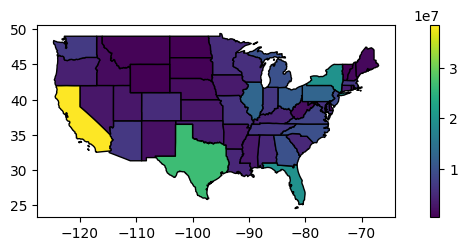

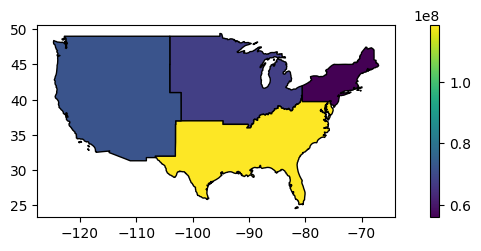

In [42]:
# States
fig, ax = plt.subplots(figsize=(9, 2.5))
us_states.plot(ax=ax, edgecolor='black', column='total_pop_15', legend=True);
# Regions
fig, ax = plt.subplots(figsize=(9, 2.5))
regions.plot(ax=ax, edgecolor='black', column='total_pop_15', legend=True);

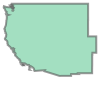

In [43]:
us_west = us_states[us_states['REGION'] == 'West']
us_west_union = us_west.geometry.union_all()
us_west_union

In [44]:
us_west

,GEOID,NAME,REGION,AREA,total_pop_10,total_pop_15,geometry
1,04,Arizona,West,295281.254837,6246816.0,6641928.0,"MULTIPOLYGON (((-114.71963 32.71876, -114.5390..."
2,08,Colorado,West,269573.057694,4887061.0,5278906.0,"MULTIPOLYGON (((-109.05008 41.00066, -108.2506..."
6,16,Idaho,West,216512.658632,1526797.0,1616547.0,"MULTIPOLYGON (((-116.91599 45.99541, -116.9595..."
13,30,Montana,West,380829.176495,973739.0,1014699.0,"MULTIPOLYGON (((-116.04919 49.00091, -115.2079..."
14,32,Nevada,West,286363.716001,2633331.0,2798636.0,"MULTIPOLYGON (((-119.99917 41.99454, -118.6964..."
26,06,California,West,409747.075055,36637290.0,38421464.0,"MULTIPOLYGON (((-118.60338 33.4781, -118.3683 ..."
38,35,New Mexico,West,314886.096814,2013122.0,2084117.0,"MULTIPOLYGON (((-109.04522 36.99908, -108.2493..."
41,41,Oregon,West,251346.240482,3761925.0,3939233.0,"MULTIPOLYGON (((-123.54766 46.25911, -123.4308..."
44,49,Utah,West,219859.796916,2657236.0,2903379.0,"MULTIPOLYGON (((-114.04172 41.99372, -113.8932..."
46,53,Washington,West,175436.047636,6561297.0,6985464.0,"MULTIPOLYGON (((-122.76994 48.22755, -122.6184..."


In [45]:
# Approach 1
sel = (us_states['REGION'] == 'West') | (us_states['NAME'] == 'Texas')
texas_union = us_states[sel]
texas_union = texas_union.geometry.union_all()
# Approach 2
us_west = us_states[us_states['REGION'] == 'West']
texas = us_states[us_states['NAME'] == 'Texas']
texas_union = pd.concat([us_west, texas]).union_all()

### 4.2.8 (on-working)